In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# changing to working directory
import os

os.chdir('gdrive/My Drive/IntroDS_unitartu')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [5]:
%matplotlib inline

In [6]:
data = pd.read_csv('data/train_cleaned.csv', parse_dates=['time']) # train data
test = pd.read_csv('data/test_cleaned.csv', parse_dates=['time'])

In [7]:
data = data.set_index('time').asfreq('H')
test = test.set_index('time').asfreq('H')

## Feature generation

We will create lags of consumption. We will create lags and moving averages of past n hours

- We will create consumption for the last 1, 3, 5
- We will create average consumption rate over 5, 10, 15, and 24 hours
- We will create consumption rate deviation over 5, 10, 15, and 24 hours

We will create 
- average consumption per hour
- average consumption per hour of each month
- A binary variable to indicate pre- and post invasion

In [8]:
data = data.assign(is_invasion= 1*(data.index >= '2022-02-26'))
test = test.assign(is_invasion= 1*(test.index >= '2022-02-26'))

In [9]:
data['is_test'] = 0
test['is_test'] = 1

In [10]:
df = pd.concat([data, test])

In [11]:
for i in [1, 3, 5]:
    df[f'last_{i}_hr'] = df.consumption.shift(i)
for i in [5, 10, 15, 24]:
    df[f'av_last_{i}_hr'] = df.consumption.shift(1).rolling(f'{i}H').mean()
    df[f'std_last_{i}_hr'] = df.consumption.shift(1).rolling(f'{i}H').std()

In [12]:
data = df[df.is_test == 0].drop('is_test', axis=1)
test = df[df.is_test == 1].drop(['is_test','consumption'], axis=1)

In [13]:
# dropping missing rows from created features
data = data.dropna()

In [14]:
created_features = data.filter(like='hr').columns

### Splitting into train and validation set

The validation data will contain consumption for the last 7 days.

In [15]:
train = data.iloc[:-7*24]
val = data.iloc[-7*24:]

In [16]:
hourly_consumption = train.groupby('hour').consumption.mean()
hourly_consumption_month = train.groupby(['month', 'hour']).consumption.mean()

hourly_consumption_month.name = 'av_hr_month_cons'
hourly_consumption.name = 'av_hr_cons'

In [17]:
# merging to dataset
train = pd.merge(train.reset_index(), hourly_consumption_month, on=['hour', 'month'], how='left').merge(
    hourly_consumption, on=['hour'], how='left')

test = pd.merge(test.reset_index(), hourly_consumption_month, on=['hour', 'month'], how='left').merge(
    hourly_consumption, on=['hour'], how='left')

val = pd.merge(val.reset_index(), hourly_consumption_month, on=['hour', 'month'], how='left').merge(
    hourly_consumption, on=['hour'], how='left')

In [18]:
train = train.set_index('time')
test = test.set_index('time')
val = val.set_index('time')

In [19]:
train.shape, val.shape

((8419, 30), (168, 30))

In [20]:
def eval_metric(ytrue, ypred):
    rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    mae = mean_absolute_error(ytrue, ypred)
    print(f'MAE: {mae:.4f}\tRMSE: {rmse:.4f}')
    
def plot_importance(model):
    imp = pd.Series(model.feature_importances_, 
                    index=xtrain.columns)
    imp = imp.sort_values()/imp.sum()
    imp.plot.barh(title=model.__class__.__name__, figsize=(8,6))
    plt.ylabel('Features')
    plt.xlabel('Importance scores')

In [21]:
# time series split
tsplit =TimeSeriesSplit(test_size=24*7)

In [22]:
xtrain = train.drop(['consumption', 'coco', 'is_invasion'], axis=1)
ytrain = train.consumption

xval = val.drop(['consumption', 'coco', 'is_invasion'], axis=1)
yval = val.consumption

In [23]:
xtrain.shape, xval.shape

((8419, 27), (168, 27))

In [24]:
seed = 4

__Optimal Parameters after hyperparameter tuning__

In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1, 
                           min_samples_leaf=15, min_samples_split=5, 
                           max_depth=20, max_features=0.9, max_samples=0.9, 
                           criterion='squared_error')

lgbm = lgb.LGBMRegressor(random_state=seed, importance_type='gain', max_depth=8,
                         min_child_samples=40, num_leaves=40, subsample=0.7,
                         objective='mae', n_estimators=1000, reg_lambda=0,
                         learning_rate=0.07, colsample_bytree=0.7)

### Training 

In [26]:
rf.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=20, max_features=0.9, max_samples=0.9,
                      min_samples_leaf=15, min_samples_split=5, n_jobs=-1,
                      random_state=4)

In [27]:
lgbm.fit(xtrain, ytrain)

LGBMRegressor(colsample_bytree=0.7, importance_type='gain', learning_rate=0.07,
              max_depth=8, min_child_samples=40, n_estimators=1000,
              num_leaves=40, objective='mae', random_state=4, reg_lambda=0,
              subsample=0.7)

### Evaluation on validation set

In [28]:
eval_metric(ytrain, rf.predict(xtrain))
eval_metric(yval, rf.predict(xval))

MAE: 0.3528	RMSE: 0.6354
MAE: 0.3307	RMSE: 0.4480


In [29]:
eval_metric(ytrain, lgbm.predict(xtrain))
eval_metric(yval, lgbm.predict(xval))

MAE: 0.2511	RMSE: 0.6427
MAE: 0.3272	RMSE: 0.4754


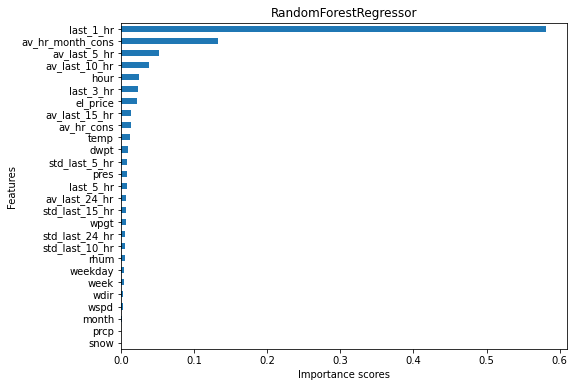

In [34]:
plot_importance(rf)

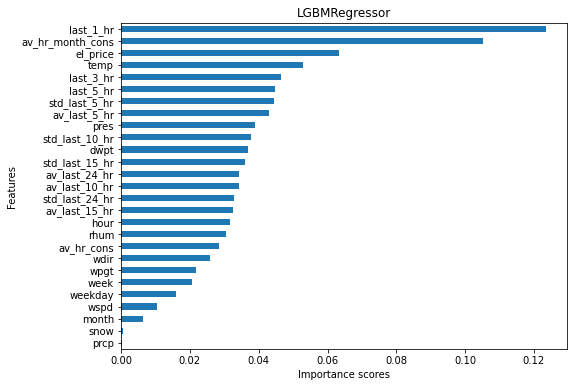

In [35]:
plot_importance(lgbm)

### Performance on Validation set

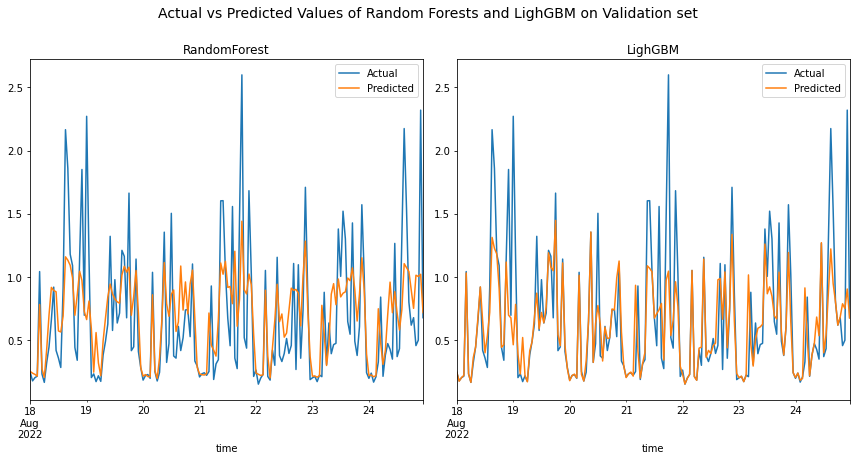

In [49]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
yval.plot(label='Actual', ax=ax[0])
pd.Series(rf.predict(xval), index=yval.index).plot(label='Predicted', ax=ax[0])
ax[0].set_title('RandomForest')
ax[0].legend()


yval.plot(label='Actual', ax=ax[1])
pd.Series(lgbm.predict(xval), index=yval.index).plot(label='Predicted', ax=ax[1])
ax[1].set_title('LighGBM')
ax[1].legend()
plt.suptitle('Actual vs Predicted Values of Random Forests and LighGBM on Validation set', y=1.06, fontsize=14)
plt.tight_layout()
plt.show()

### Predictions

Here, we will fit the models on the whole historical data and then predict on the test set

In [37]:
# adding to main data
data[['av_hr_month_cons', 'av_hr_cons']] = pd.concat([xtrain, xval])[['av_hr_month_cons', 'av_hr_cons']]

In [38]:
rf.fit(data[xtrain.columns], data.consumption)

RandomForestRegressor(max_depth=20, max_features=0.9, max_samples=0.9,
                      min_samples_leaf=15, min_samples_split=5, n_jobs=-1,
                      random_state=4)

In [39]:
lgbm.fit(data[xtrain.columns], data.consumption)

LGBMRegressor(colsample_bytree=0.7, importance_type='gain', learning_rate=0.07,
              max_depth=8, min_child_samples=40, n_estimators=1000,
              num_leaves=40, objective='mae', random_state=4, reg_lambda=0,
              subsample=0.7)

In [40]:
rf_preds = pd.DataFrame({'time' : test.index, 
                         'consumption':rf.predict(test[xtrain.columns].fillna(0))})


lgb_preds = pd.DataFrame({'time': test.index, 
                         'consumption':lgbm.predict(test[xtrain.columns].fillna(0))})

In [41]:
rf_preds.consumption.describe()

count    168.000000
mean       0.488189
std        0.105686
min        0.232317
25%        0.419716
50%        0.482541
75%        0.547133
max        0.748528
Name: consumption, dtype: float64

In [42]:
lgb_preds.consumption.describe()

count    168.000000
mean       0.497755
std        0.197435
min        0.201195
25%        0.332189
50%        0.438005
75%        0.643599
max        1.134308
Name: consumption, dtype: float64

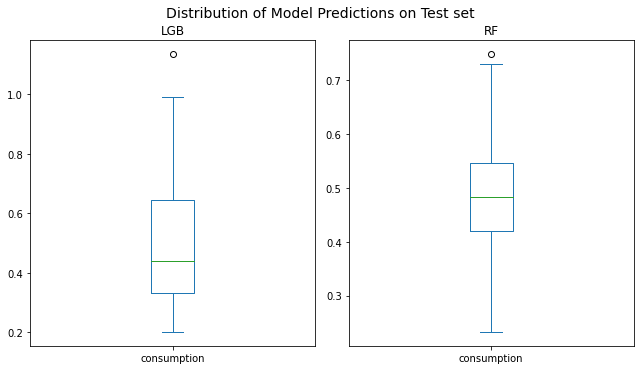

In [50]:
fig, ax = plt.subplots(1,2,figsize=(9,5))
lgb_preds.consumption.plot.box(ax=ax[0], title='LGB')
rf_preds.consumption.plot.box(ax=ax[1], title='RF')
plt.suptitle('Distribution of Model Predictions on Test set', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Cross validation

To check how model's can perform with unseen data

In [44]:
def cross_validation_scores(model):
    cvs =  -cross_val_score(model, data[xtrain.columns], data.consumption, cv=tsplit,
                            n_jobs=8, scoring='neg_mean_absolute_error')
    print('scores: {}\nMean: {:.5f} +- {:.5f}'.format(cvs, cvs.mean(), cvs.std()))

In [45]:
cross_validation_scores(rf)

scores: [0.30644044 0.30587783 0.31913135 0.2836984  0.33067971]
Mean: 0.30917 +- 0.01568


In [46]:
cross_validation_scores(lgbm)

scores: [0.2856468  0.28977295 0.29430425 0.25489009 0.32717356]
Mean: 0.29036 +- 0.02303
